In [1]:
import os
import math

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential, Linear

import torch_geometric as tg
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import CGConv, NNConv, Set2Set
from torch_geometric.nn.aggr import AttentionalAggregation

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, PredefinedSplit
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer
from sklearn.base import BaseEstimator, RegressorMixin

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

import rdkit
from rdkit import Chem
import rdkit.Chem.rdchem as rdc

import matplotlib.pyplot as ax1


In [2]:
import sys
sys.path.append(os.getcwd())

from src.load_utils import *
from src.feature_importance import *

In [ ]:
# Labels/Hyperparameter definition

target_cols_labels = [
    "CONDUCTIVITY",
    "TFSI Diffusivity",
    "Li Diffusivity",
    "Poly Diffusivity",
    "Transference Number",
]

csv_path = 'data/temp_full_data.csv'

# Training Parameters
batch_size = 256
num_epochs = 200

# Hidden layer parameters
fea_dim=96
n_layers=4
n_hidden=2

# Adam optimizer hyperparameters
learning_rate = 1e-4
weight_decay = 1e-6

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)
save_dir = "model_out"
os.makedirs(save_dir, exist_ok=True)

In [4]:
# Setup feature ranges based on SMILES strings

def compute_feature_ranges(list_of_smiles):
    atom_symbols = set()
    degrees = set()
    formal_charges = set()
    num_hs = set()
    hybridizations = set()
    
    bond_types = set()
    bond_stereo = set()
    conjugations = set()

    for smile in list_of_smiles:
        mol = Chem.MolFromSmiles(smile)
        if mol is None:
            continue
        # mol_atoms = [atom.GetSymbol() for atom in mol.GetAtoms()]
        for atom in mol.GetAtoms():
            atom_symbols.add(atom.GetSymbol())
            degrees.add(atom.GetDegree())
            formal_charges.add(atom.GetFormalCharge())
            num_hs.add(atom.GetTotalNumHs())
            hybridizations.add(str(atom.GetHybridization()))

        for bond in mol.GetBonds():
            bond_types.add(str(bond.GetBondType()))
            bond_stereo.add(str(bond.GetStereo()))
            conjugations.add(bond.GetIsConjugated())
    
    x_map = {
        "atomic_symbol": sorted(atom_symbols),
        "degree": sorted(degrees),
        "formal_charge": sorted(formal_charges),
        "num_hs": sorted(num_hs),
        "hybridization": sorted(hybridizations),
        "is_aromatic": [False, True],
        "is_in_ring": [False, True],
    }

    e_map = {
        "bond_type": sorted(bond_types),
        "stereo": sorted(bond_stereo),
        "is_conjugated": [False, True],
    }
    return x_map, e_map

def add_unknowns(x_map: dict, e_map: dict):
    # Add UNK token to categorical lists if not present
    for k in ["atomic_symbol", "hybridization"]:
        if "UNK" not in x_map[k]:
            x_map[k].append("UNK")
    # For degree/formal_charge/num_hs: we will keep them as discrete sets but
    # if unseen values appear we will map to a min/max or UNK index — we append 'UNK' as str to be safe.
    for k in ["degree", "formal_charge", "num_hs"]:
        # convert to strings? we keep them as numbers but ensure UNK presence for one_hot implementation
        if "UNK" not in x_map[k]:
            x_map[k] = list(x_map[k]) + ["UNK"]

    for k in ["bond_type", "stereo"]:
        if "UNK" not in e_map[k]:
            e_map[k].append("UNK")

    # ensure boolean lists contain False/True
    x_map['is_aromatic'] = [False, True]
    x_map['is_in_ring'] = [False, True]
    e_map['is_conjugated'] = [False, True]

    return x_map, e_map

def get_bond_feature_dim(e_map):
    dim = (
        len(e_map["bond_type"]) +
        len(e_map["stereo"]) +
        len(e_map["is_conjugated"])
    )
    return dim

In [5]:
# Feature Definition: one-hot, atom (node), bond (edge), generate graph from SMILES

def one_hot(x, choices):
    if x not in choices:
        x = "UNK"
    return np.array([x == c for c in choices], dtype=float)

def atom_features(atom, x_map):
    symbol = atom.GetSymbol()
    degree = atom.GetDegree()
    fc = atom.GetFormalCharge()
    hs = atom.GetTotalNumHs()
    hyb = str(atom.GetHybridization())
    aromatic = atom.GetIsAromatic()
    ring = atom.IsInRing()

    return np.concatenate([
        one_hot(symbol, x_map["atomic_symbol"]),
        one_hot(degree, x_map["degree"]),
        one_hot(fc, x_map["formal_charge"]),
        one_hot(hs, x_map["num_hs"]),
        one_hot(hyb, x_map["hybridization"]),
        one_hot(aromatic, x_map["is_aromatic"]),
        one_hot(ring, x_map["is_in_ring"]),
    ])


def bond_features(bond, e_map):
    btype = str(bond.GetBondType())
    stereo = str(bond.GetStereo())
    conj = bond.GetIsConjugated()

    return np.concatenate([
        one_hot(btype, e_map["bond_type"]),
        one_hot(stereo, e_map["stereo"]),
        one_hot(conj, e_map["is_conjugated"]),
    ])

def smiles_to_graph(smiles, x_map, e_map, add_h: bool = True, add_self_loops=True):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES: {smiles}")
    if add_h:
        mol = Chem.AddHs(mol)
    
    atom_feats = []
    edge_index = []
    edge_feats = []

    # Atom features
    for atom in mol.GetAtoms():
        atom_feats.append(atom_features(atom, x_map))

    # Bond features
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        bf = bond_features(bond, e_map)
        edge_index.append([i, j])
        edge_feats.append(bf)

        edge_index.append([j, i])
        edge_feats.append(bf)

    if add_self_loops:
        bond_dim = (
            len(e_map["bond_type"]) +
            len(e_map["stereo"]) +
            len(e_map["is_conjugated"])
        )
        zero_bond = np.zeros(bond_dim, dtype=float)

        num_atoms = len(atom_feats)
        for i in range(num_atoms):
            edge_index.append([i, i])
            edge_feats.append(zero_bond)

    x = torch.tensor(np.array(atom_feats), dtype=torch.float)
    edge_index = torch.tensor(np.array(edge_index).T, dtype=torch.long)
    edge_attr = torch.tensor(np.array(edge_feats), dtype=torch.float)
    
    g = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    g.num_nodes = x.size(0)
    
    return g

In [6]:
# Process CSV file, generate graphs

class PolymerCSV(InMemoryDataset):
    def __init__(self, csv_path: str, target_cols: list[str], x_map: dict, e_map: dict, add_h: bool = True):
        super().__init__(None)
        self.df = pd.read_csv(csv_path)
        self.target_cols = target_cols
        
        self.x_map = x_map
        self.e_map = e_map
        self.add_h = add_h

        data_list = []
        for idx, row in self.df.iterrows():
            smi = row.get("Mol_smiles_clean")
            if pd.isna(smi):
                continue
            try:
                g = smiles_to_graph(smi, self.x_map, self.e_map, self.add_h, True)
            except Exception as e:
                print(f"[Warning] Skipping SMILES {smi}: {e}")
                continue

            # collect targets and mask
            y = []
            mask = []
            for c in self.target_cols:
                val = row.get(c, np.nan) # get column value or NaN if unavailable
                if pd.isna(val):
                    y.append(0.0)
                    mask.append(0.0)
                else:
                    y.append(float(val))
                    mask.append(1.0)

            g.y = torch.tensor([y], dtype=torch.float)
            g.y_mask = torch.tensor([mask], dtype=torch.float)
            
            # optional: save trajectory id as meta
            if "Trajectory ID" in row:
                g.traj_id = int(row["Trajectory ID"])
            data_list.append(g)

        self.data, self.slices = self.collate(data_list)

In [7]:
# Multitask CGCNN setup

class MultiTaskCGCNN(nn.Module):
    def __init__(self, node_in: int, edge_in: int, fea_dim=96, n_layers=4, n_hidden=2, out_dim=5, include_mol_features=False, mol_dim=0):
        super().__init__()
        self.node_embed = Linear(node_in, fea_dim)
        self.edge_embed = Linear(edge_in, fea_dim)
        self.include_mol_features = include_mol_features
        self.mol_dim = mol_dim

        self.convs = nn.ModuleList([
            CGConv(channels=fea_dim, dim=fea_dim, aggr="mean", batch_norm=True)
            for _ in range(n_layers)
        ])

        self.pool = AttentionalAggregation(
            gate_nn=Sequential(Linear(fea_dim, fea_dim), Linear(fea_dim, 1)),
            nn=Sequential(Linear(fea_dim, fea_dim), Linear(fea_dim, fea_dim))
        )

        if self.include_mol_features:
            if self.mol_dim == 0:
                raise ValueError("Must supply number of molecular features (>0)")
            fea_dim += self.mol_dim
        self.hiddens = nn.ModuleList([Linear(fea_dim, fea_dim) for _ in range(n_hidden)])
        self.head = Linear(fea_dim, out_dim)

    def forward(self, data: tuple[Data, torch.Tensor]):
        graph_data, mol_data = data
        x = F.leaky_relu(self.node_embed(graph_data.x))
        e = F.leaky_relu(self.edge_embed(graph_data.edge_attr))
        
        for conv in self.convs:
            x = conv(x, graph_data.edge_index, e)
        g = self.pool(x, graph_data.batch)
        
        if self.include_mol_features:
            g = torch.cat((g, mol_data), dim=1)
        
        for h in self.hiddens:
            g = F.leaky_relu(h(g))

        out = self.head(g)
        return out

In [8]:
# Masked MSE & MAE

def masked_mse_loss(pred: torch.Tensor, y: torch.Tensor, mask: torch.Tensor):
    # pred,y,mask -> [B, T]
    
    diff = (pred - y) * mask
    denom = mask.sum()
    if denom.item() == 0:
        return torch.tensor(0.0, device=pred.device, requires_grad=True)
    return (diff * diff).sum() / denom


def masked_mae(pred: np.ndarray, y: np.ndarray, mask: np.ndarray):
    # numpy arrays
    diff = np.abs(pred - y) * mask
    denom = mask.sum()
    if denom == 0:
        return 0.0
    return diff.sum() / denom

In [9]:
# Train and evaluate epochs

def train_epoch(model, loader, optimizer, scaler: StandardScaler, device):
    model.train()
    total_loss = 0.0
    for batch1, batch2 in loader:
        batch1 = batch1.to(device)
        batch2 = batch2.to(device)
        # scale batch targets (y) using scaler trained on train set
        # scaler expects 2D arrays; convert
        y_cpu = batch1.y.cpu().numpy()
        # IMPORTANT: scaler.transform requires shape [n_samples, n_targets]
        # print(np.shape(y_cpu))
        y_scaled = torch.tensor(scaler.transform(y_cpu), dtype=torch.float, device=device)

        optimizer.zero_grad()
        out = model((batch1, batch2))  # [B, T]
        loss = masked_mse_loss(out, y_scaled, batch1.y_mask)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch1.num_graphs
    
    loss = total_loss / len(loader.dataset)
    return loss


def eval_epoch(model, loader, scaler: StandardScaler, device):
    model.eval()
    total_loss = 0.0
    total_mae = 0.0

    all_preds = []
    all_preds_scaled = []
    all_ys = []
    all_ys_scaled = []
    all_masks = []

    with torch.no_grad():
        for batch1, batch2 in loader:
            batch1 = batch1.to(device)
            batch2 = batch2.to(device)

            y_cpu = batch1.y.cpu().numpy()
            y_scaled_np = scaler.transform(y_cpu)
            y_scaled = torch.tensor(y_scaled_np, dtype=torch.float, device=device)

            out_scaled = model((batch1, batch2))
            out_scaled_np = out_scaled.cpu().numpy()

            loss = masked_mse_loss(out_scaled, y_scaled, batch1.y_mask)
            total_loss += loss.item() * batch1.num_graphs

            

            # collect predictions and ground truth in original scale for MAE
            out_unscaled = scaler.inverse_transform(out_scaled.cpu().numpy())
            y_unscaled = batch1.y.cpu().numpy()  # raw y already unscaled

            all_preds.append(out_unscaled)
            all_preds_scaled.append(out_scaled_np)
            all_ys.append(y_unscaled)
            all_ys_scaled.append(y_scaled_np)

            all_masks.append(batch1.y_mask.cpu().numpy())

    if len(all_preds) == 0:
        return total_loss / max(1, len(loader.dataset)), None

    preds = np.vstack(all_preds)
    preds_scaled = np.vstack(all_preds_scaled)
    ys = np.vstack(all_ys)
    ys_scaled = np.vstack(all_ys_scaled)
    masks = np.vstack(all_masks)


    # per task loss/MAE
    T = preds.shape[1]
    per_task_mae = []
    per_task_r2 = []

    for t in range(T):
        mask_t = masks[:, t].astype(bool)

        if mask_t.sum() == 0:
            per_task_mae.append(None)
            per_task_r2.append(None)
            continue

        pred_t = preds_scaled[:, t][mask_t]
        y_t = ys_scaled[:, t][mask_t]

        mae_t = np.mean(np.abs(pred_t - y_t))
        per_task_mae.append(mae_t)

        if len(y_t) > 1:
            per_task_r2.append(r2_score(y_t, pred_t))
        else:
            per_task_r2.append(None)
            
    # compute global loss/MAE across all tasks using masking
    overall_loss = total_loss / len(loader.dataset)
    overall_mae = masked_mae(preds, ys, masks)
    overall_r2 = np.mean(per_task_r2)

    return overall_loss, overall_mae, overall_r2, per_task_mae, per_task_r2, preds, ys, masks

In [10]:
# Create training, validation, testing splits

def create_splits(df: pd.DataFrame, frac_train=0.8, frac_val=0.125):
    n = len(df)
    test_size = 1.0 - frac_train
    idx = np.arange(n)
    train_idx, test_idx = train_test_split(idx, test_size=test_size)
    train_idx, val_idx = train_test_split(train_idx, test_size=frac_val / frac_train)

    return train_idx.tolist(), val_idx.tolist(), test_idx.tolist()

In [ ]:
### Build, train, and test model

def model_execution(csv_path=csv_path,
                    target_cols=target_cols_labels,
                    include_mol_features=False,
                    batch_size=batch_size,
                    num_epochs=num_epochs,
                    fea_dim=fea_dim,
                    n_layers=n_layers,
                    n_hidden=n_hidden,
                    learning_rate=learning_rate,
                    weight_decay=weight_decay,
                    return_predictions=False,
                    verbose=0):

    # Load CSV + build feature maps
    df = pd.read_csv(csv_path)
    smiles_list = df["Mol_smiles_clean"].dropna().astype(str).tolist()

    mol_cols = [
        c for c in df.columns if c not in [*target_cols, "Mol_smiles_clean", 'Unnamed: 0']
    ]
    mol_data = torch.tensor(df[mol_cols].values, dtype=torch.float32)

    x_map, e_map = compute_feature_ranges(smiles_list)
    x_map, e_map = add_unknowns(x_map, e_map)

    # Train/val/test splits
    train_idx, val_idx, test_idx = create_splits(df, frac_train=0.8, frac_val=0.125)

    dataset = PolymerCSV(csv_path, target_cols, x_map=x_map, e_map=e_map, add_h=True)

    if verbose:
        print(f"Found {len(smiles_list)} SMILES in CSV.")

        print("\n ===> Atom feature map sizes <===")
        for k, v in x_map.items():
            print(f"{k:>15}: {len(v)}")

        print("\n ===> Edge feature map sizes <===")
        for k, v in e_map.items():
            print(f"{k:>15}: {len(v)}")

        print(f"\nSplit sizes:\n   Training = {len(train_idx)}\n   Validation = {len(val_idx)}\n   Testing = {len(test_idx)}")
        print(f"\nTotal graphs built: {len(dataset)}")

    train_ds = torch.utils.data.Subset(dataset, train_idx)
    val_ds   = torch.utils.data.Subset(dataset, val_idx)
    test_ds  = torch.utils.data.Subset(dataset, test_idx)
    
    train_mol_ds = torch.utils.data.Subset(mol_data, train_idx)
    val_mol_ds   = torch.utils.data.Subset(mol_data, val_idx)
    test_mol_ds  = torch.utils.data.Subset(mol_data, test_idx)

    train_loader = DataLoader([(d, v) for d, v in zip(train_ds, train_mol_ds)], batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader([(d, v) for d, v in zip(val_ds, val_mol_ds)],     batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader([(d, v) for d, v in zip(test_ds, test_mol_ds)],   batch_size=batch_size, shuffle=False)

    # Fit scaler only on training targets
    def collect_targets(subset):
        Ys = [g.y.numpy() for g in subset]
        return np.vstack(Ys) if Ys else np.zeros((0, len(target_cols)))

    y_train = collect_targets(train_ds)
    if y_train.shape[0] == 0:
        raise RuntimeError("No training examples with targets found!")

    scaler = StandardScaler()
    scaler.fit(y_train)

    # Build model + optimizer
    sample = dataset[0]
    node_in = sample.x.shape[1]
    edge_in = sample.edge_attr.shape[1]
    out_dim = len(target_cols)
    mol_dim = len(mol_cols)

    model = MultiTaskCGCNN(
        node_in=node_in,
        edge_in=edge_in,
        fea_dim=fea_dim,
        n_layers=n_layers,
        n_hidden=n_hidden,
        out_dim=out_dim,
        include_mol_features=include_mol_features,
        mol_dim=mol_dim
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    best_val = float("inf")

    if include_mol_features:
        model_state_name = 'naive_model_nomol'
    else:
        model_state_name = 'naive_model_withmol'

    best_path = os.path.join(save_dir, f"{model_state_name}.pth")

    # Unified metrics structure
    metrics = {
        "train": {
            "loss": [],
            "mae":  [],
            "r2":   [],
            "per_task_mae": {t: [] for t in target_cols},
            "per_task_r2":  {t: [] for t in target_cols},
        },
        "val": {
            "loss": [],
            "mae":  [],
            "r2":   [],
            "per_task_mae": {t: [] for t in target_cols},
            "per_task_r2":  {t: [] for t in target_cols},
        },
        "test": {
            "loss": None,
            "mae":  None,
            "r2":   None,
            "per_task_mae": {t: None for t in target_cols},
            "per_task_r2":  {t: None for t in target_cols},
        }
    }


    # Training loop
    for epoch in tqdm(range(1, num_epochs + 1)):

        # training
        train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
        tr_loss, tr_mae, tr_r2, tr_pt_mae, tr_pt_r2, _, _, _ = eval_epoch(
            model, train_loader, scaler, device
        )
        tr_loss = train_loss   # override with actual loss from train_epoch

        # validation
        val_loss, val_mae, val_r2, val_pt_mae, val_pt_r2, _, _, _ = eval_epoch(
        model, test_loader, scaler, device
    )

        # store metrics
        metrics["train"]["loss"].append(tr_loss)
        metrics["train"]["mae"].append(tr_mae)
        metrics["train"]["r2"].append(tr_r2)

        metrics["val"]["loss"].append(val_loss)
        metrics["val"]["mae"].append(val_mae)
        metrics["val"]["r2"].append(val_r2)

        for i, t in enumerate(target_cols):
            metrics["train"]["per_task_mae"][t].append(tr_pt_mae[i])
            metrics["train"]["per_task_r2"][t].append(tr_pt_r2[i])
            metrics["val"]["per_task_mae"][t].append(val_pt_mae[i])
            metrics["val"]["per_task_r2"][t].append(val_pt_r2[i])

        # checkpoint
        if val_loss < best_val:
            best_val = val_loss
            torch.save(
                {
                    "model_state": model.state_dict(),
                    "scaler": scaler,
                    "x_map": x_map,
                    "e_map": e_map,
                    "metrics": metrics,
                },
                best_path,
            )

    # Final test evaluation
    ckpt = torch.load(best_path, map_location=device, weights_only=False)


    model.load_state_dict(ckpt["model_state"])
    scaler = ckpt["scaler"]

    test_loss, test_mae, test_r2, test_pt_mae, test_pt_r2, test_preds, test_ys, test_masks = eval_epoch(
        model, test_loader, scaler, device
    )

    metrics["test"]["loss"] = test_loss
    metrics["test"]["mae"]  = test_mae
    metrics["test"]["r2"]   = test_r2
    for i, t in enumerate(target_cols):
        metrics["test"]["per_task_mae"][t] = test_pt_mae[i]
        metrics["test"]["per_task_r2"][t]  = test_pt_r2[i]

    if return_predictions:
        return model, metrics, scaler, test_preds, test_ys, test_masks
    else:
        return model, metrics, scaler


In [72]:
# Plot metrics for final model

def plot_all_metrics(metrics, target_cols, num_epochs):
    epochs = np.arange(1, num_epochs + 1)


    fig_global, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(18,6))

    # GLOBAL LOSS
    ax1.grid(True)
    ax1.plot(epochs, metrics["train"]["loss"], label="Train Loss")
    ax1.plot(epochs, metrics["val"]["loss"],   label="Val Loss")
    ax1.scatter([num_epochs], [metrics["test"]["loss"]], color="red", label="Test Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Scaled MSE Loss")
    ax1.set_title("Global Loss")
    ax1.legend()

    # GLOBAL MAE
    ax2.grid(True)
    ax2.plot(epochs, metrics["train"]["mae"], label="Train MAE")
    ax2.plot(epochs, metrics["val"]["mae"],   label="Val MAE")
    ax2.scatter([num_epochs], [metrics["test"]["mae"]], color="red", label="Test MAE")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("MAE")
    ax2.set_title("Global MAE")
    ax2.legend()

    # GLOBAL R2
    ax3.grid(True)
    ax3.plot(epochs, metrics["train"]["r2"], label="Train R2")
    ax3.plot(epochs, metrics["val"]["r2"],   label="Val R2")
    ax3.scatter([num_epochs], [metrics["test"]["r2"]], color="red", label="Test R2")
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("R2 Score")
    ax3.set_title("Global R2")
    ax3.legend()

    fig_global.tight_layout()
    plt.show()

    # PER-TASK MAE SUBPLOTS
    T = len(target_cols)
    ncols = math.ceil(math.sqrt(T))
    nrows = math.ceil(T / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 12))
    axes = axes.flatten()

    for idx, t in enumerate(target_cols):
        ax = axes[idx]
        train_vals = metrics["train"]["per_task_mae"][t]
        val_vals   = metrics["val"]["per_task_mae"][t]
        test_val   = metrics["test"]["per_task_mae"][t]

        ax.plot(epochs, train_vals, label="Train", linewidth=2)
        ax.plot(epochs, val_vals,   label="Val",   linewidth=2)
        if test_val is not None:
            ax.scatter([num_epochs], [test_val], color="red", s=40, label="Test")

        ax.set_title(f"{t} — MAE")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("MAE")
        ax.grid(True)
        ax.legend()

    # hide any unused axes
    for j in range(idx+1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Per-Task MAE Over Time", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

    # PER-TASK R2 SUBPLOTS
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 12))
    axes = axes.flatten()

    for idx, t in enumerate(target_cols):
        ax = axes[idx]
        ax.grid(True)

        train_vals = metrics["train"]["per_task_r2"][t]
        val_vals   = metrics["val"]["per_task_r2"][t]
        test_val   = metrics["test"]["per_task_r2"][t]

        ax.plot(epochs, train_vals, label="Train", linewidth=2)
        ax.plot(epochs, val_vals,   label="Val",   linewidth=2)
        if test_val is not None:
            ax.scatter([num_epochs], [test_val], color="red", s=40, label="Test")

        ax.set_title(f"{t} — R2")
        ax.set_ylim((-0.5,1))
        ax.set_xlabel("Epoch")
        ax.set_ylabel("R2")
        ax.legend()

    # hide any unused axes
    for j in range(idx+1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Per-Task R2 Over Time", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()


In [13]:
# final_model, final_metrics, _, _, _, _ = model_execution('./data/temp_full_data.csv', target_cols_labels, include_mol_features=False, return_predictions=True)
# plot_all_metrics(final_metrics, target_cols, num_epochs)

/home/ericg5/anaconda3/envs/keras_pytorch/lib/python3.12/site-packages/torch/cuda/__init__.py:235: UserWarning: 
NVIDIA GeForce RTX 5090 with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_89 sm_90 compute_90.
If you want to use the NVIDIA GeForce RTX 5090 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(
100%|██████████| 200/200 [00:42<00:00,  4.68it/s]


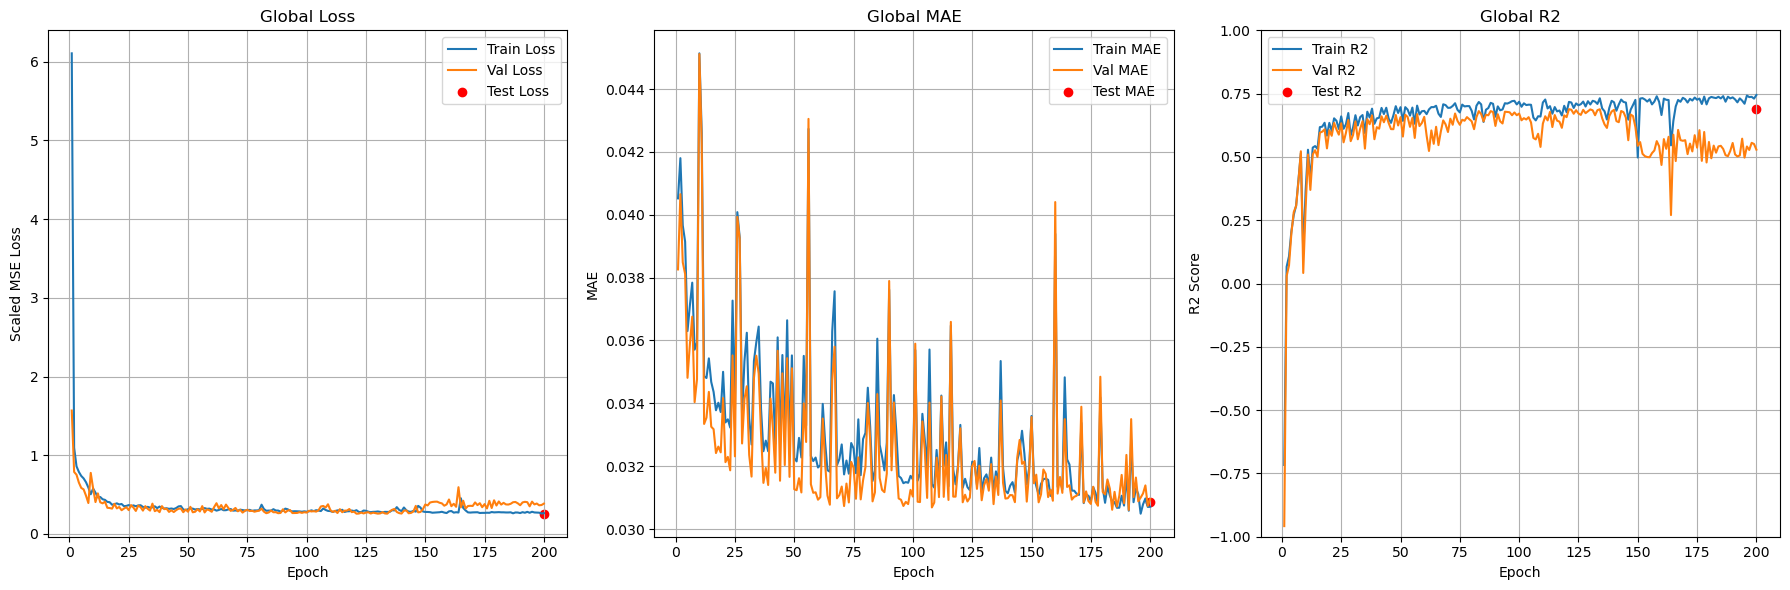

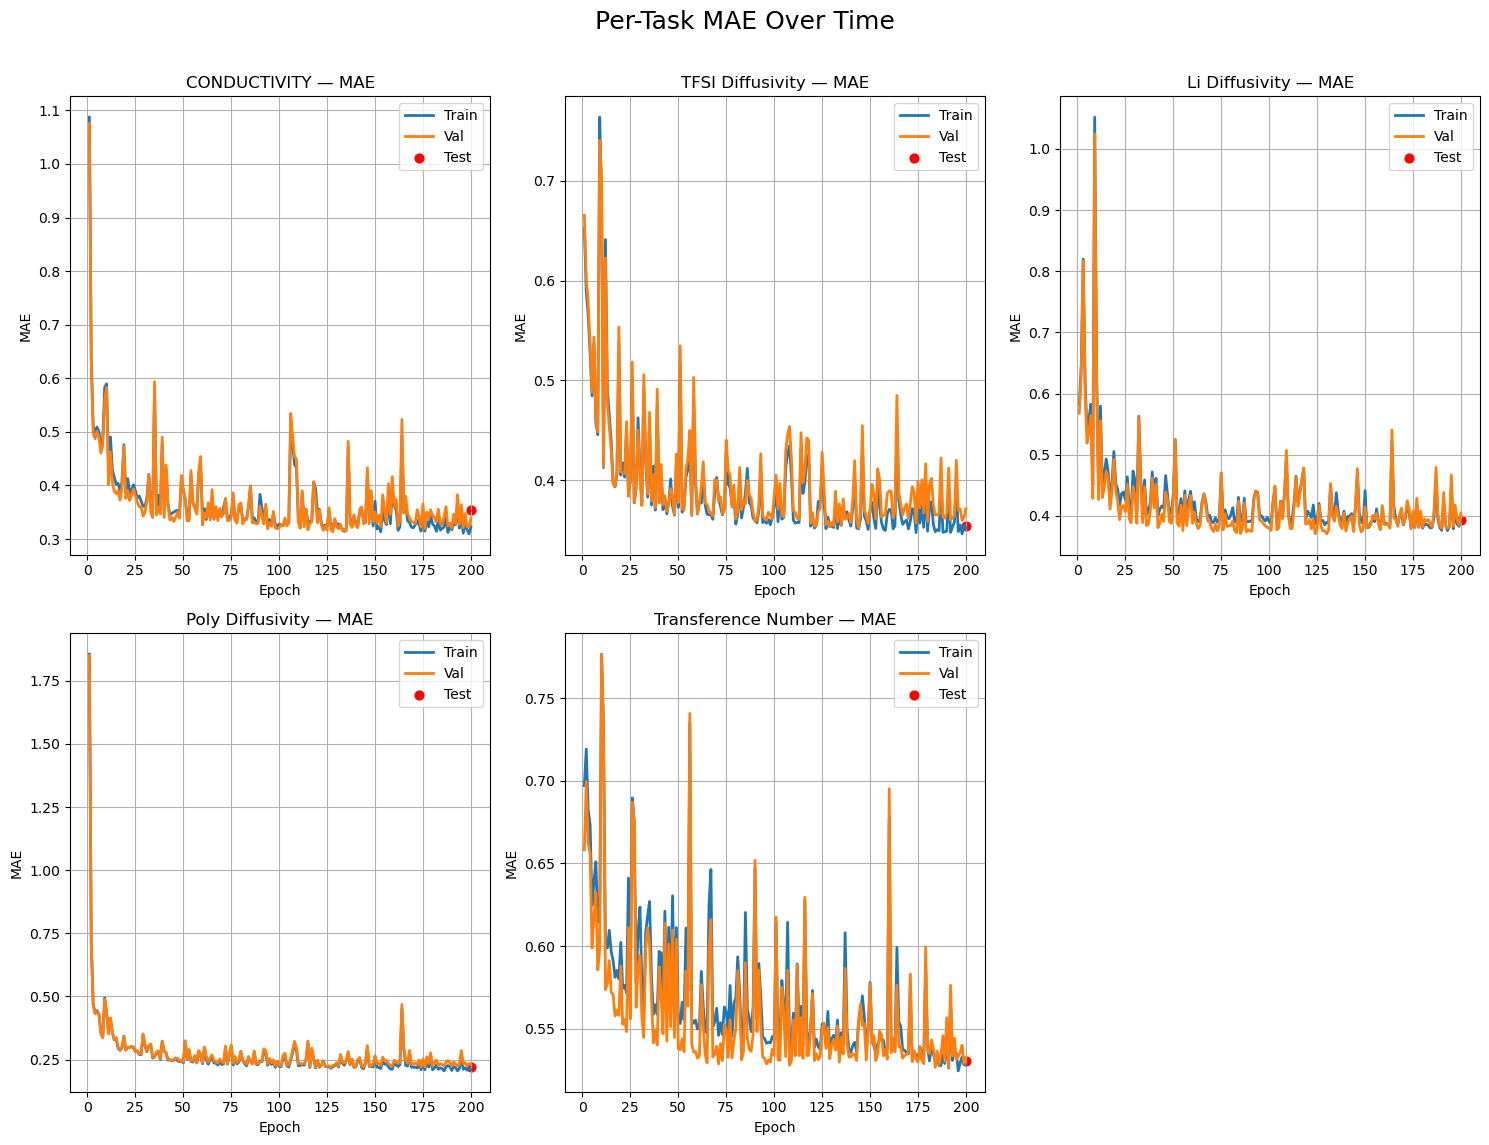

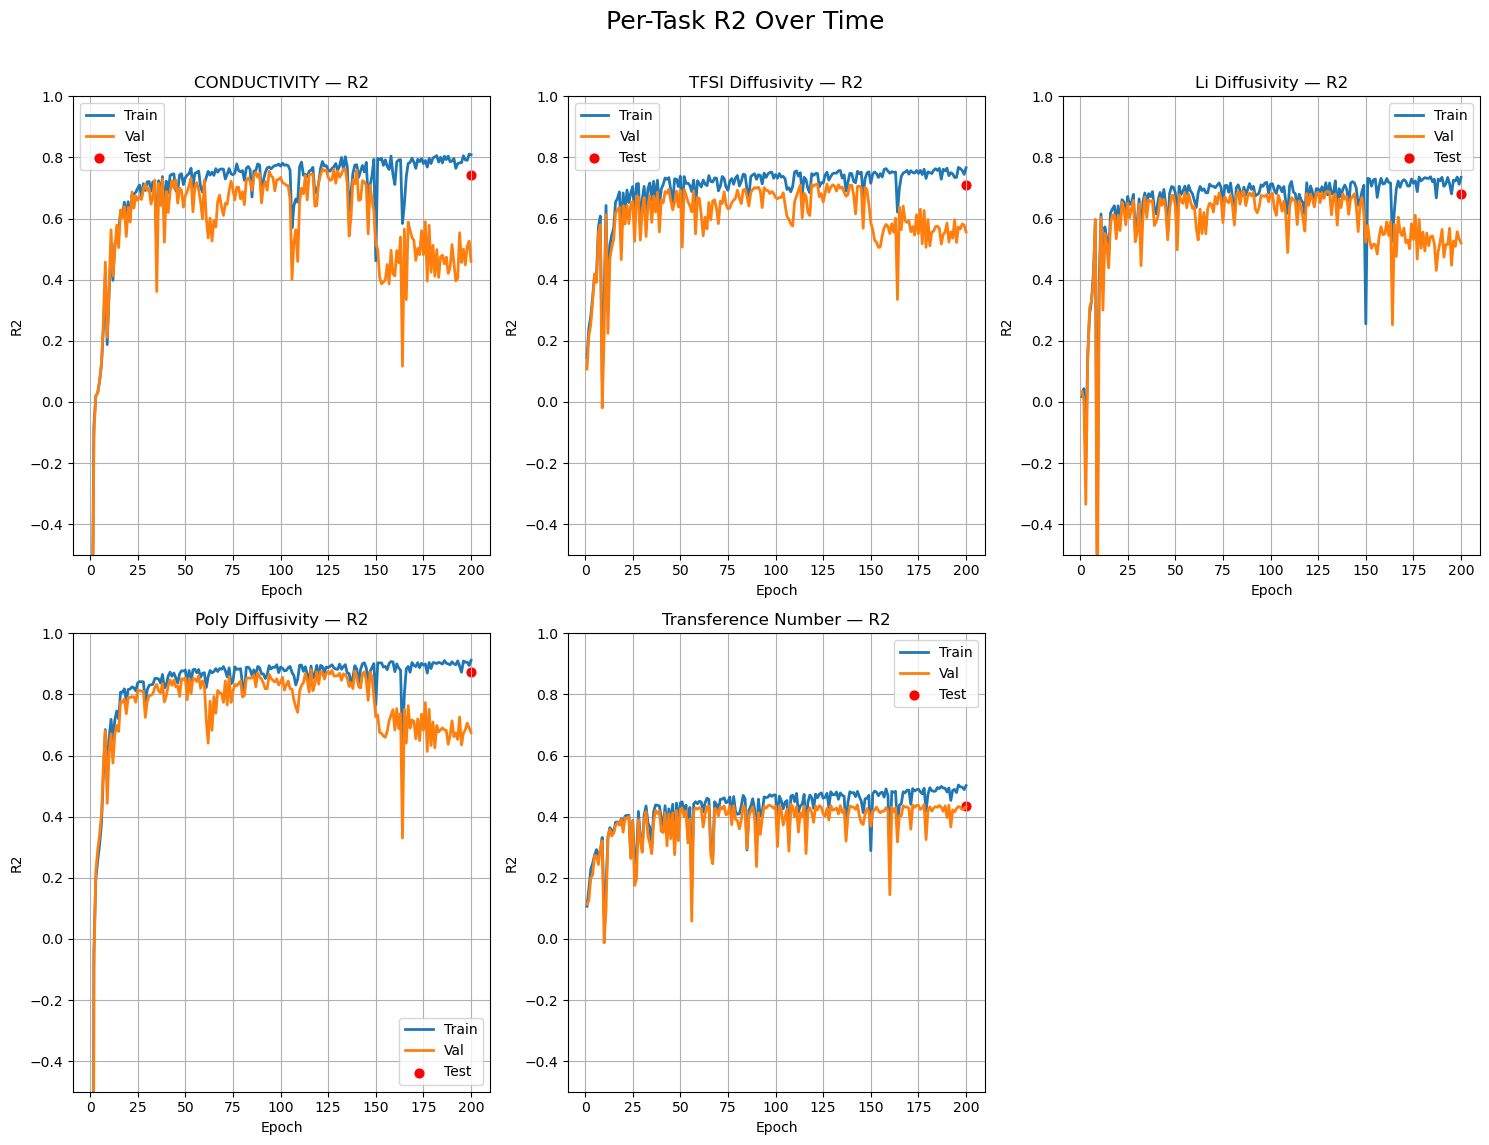

In [14]:
final_model2, final_metrics2, _, _, _, _ = model_execution('./data/temp_full_data.csv', target_cols_labels, include_mol_features=True, return_predictions=True)
plot_all_metrics(final_metrics2, target_cols_labels, num_epochs)

In [ ]:
hyperparameter_searchspace_long = {
    "batch_size":    Integer(32,1024, prior='log-uniform', base=2),
    "num_epochs":    Integer(64,256),
    "fea_dim":       Integer(32,128),
    "n_layers":      Integer(2,8),
    "n_hidden":      Integer(2,8),
    "learning_rate": Real(1e-6,1e-3,prior='log-uniform'),
    "weight_decay":  Real(1e-8,1e-3,prior='log-uniform'),
}


In [56]:
class CGCNN_Estimator(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        csv_path,
        target_cols,
        include_mol_features=False,
        batch_size=batch_size,
        num_epochs=num_epochs,
        fea_dim=fea_dim,
        n_layers=n_layers,
        n_hidden=n_hidden,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        verbose=0
    ):
        # static info
        self.csv_path = csv_path
        self.target_cols = target_cols
        self.include_mol_features = include_mol_features
        self.verbose = verbose

        # hyperparameters (optimizable)
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.fea_dim = fea_dim
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

        # results & state
        self.model_ = None
        self.metrics_ = None
        self.scaler_ = None
        self.test_preds_ = None
        self.test_targets_ = None
        self.test_masks_ = None

    def fit(self, X=None, y=None):
        (self.model_,
         self.metrics_,
         self.scaler_,
         self.test_preds_,
         self.test_targets_,
         self.test_masks_) = model_execution(
            csv_path=self.csv_path,
            target_cols=self.target_cols,
            include_mol_features=self.include_mol_features,
            batch_size=self.batch_size,
            num_epochs=self.num_epochs,
            fea_dim=self.fea_dim,
            n_layers=self.n_layers,
            n_hidden=self.n_hidden,
            learning_rate=self.learning_rate,
            weight_decay=self.weight_decay,
            return_predictions=True,
            verbose=self.verbose
        )

        return self
    def score(self, X, y=None):
        r2 = self.metrics_["test"]["r2"]
        mae = self.metrics_["test"]["mae"]
        return r2-mae
    
    def predict(self, X):
        # optional, not needed for BayesSearchCV
        pass



In [ ]:
estimator_nomol = CGCNN_Estimator(
    csv_path=csv_path,
    target_cols=target_cols_labels,
    include_mol_features=False
)

estimator_withmol = CGCNN_Estimator(
    csv_path=csv_path,
    target_cols=target_cols_labels,
    include_mol_features=True
)

full_df = pd.read_csv(csv_path)

mol_cols = [c for c in full_df.columns if c not in [*target_cols_labels, 'Unnamed: 0']]

x_train, x_test, y_train, y_test = train_test_split(full_df[target_cols_labels], full_df[mol_cols])

dummy_X = np.zeros((2, 1))
dummy_y = np.zeros((2, 1))
dummy_split = PredefinedSplit(test_fold=[-1, 0])

optimizer_nomol = BayesSearchCV(
    estimator=estimator_withmol,
    search_spaces=hyperparameter_searchspace_long,
    n_iter=100,
    cv=dummy_split,
    n_jobs=1,
    verbose=3
)

optimizer_nomol.fit(dummy_X, dummy_y)

optimizer_withmol = BayesSearchCV(
    estimator=estimator_withmol,
    search_spaces=hyperparameter_searchspace_long,
    n_iter=100,
    cv=dummy_split,
    n_jobs=1,
    verbose=3
)

optimizer_withmol.fit(dummy_X, dummy_y)

Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 141/141 [01:01<00:00,  2.31it/s]


[CV 1/1] END batch_size=83, fea_dim=65, learning_rate=2.7749579385651325e-05, n_hidden=7, n_layers=6, num_epochs=141, weight_decay=4.442581941188774e-05;, score=0.673 total time= 1.1min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 146/146 [00:36<00:00,  3.95it/s]


[CV 1/1] END batch_size=669, fea_dim=102, learning_rate=9.233436650968936e-06, n_hidden=2, n_layers=8, num_epochs=146, weight_decay=1.376070023803791e-06;, score=0.327 total time=  39.9s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 133/133 [00:48<00:00,  2.76it/s]


[CV 1/1] END batch_size=84, fea_dim=60, learning_rate=3.155950216841063e-06, n_hidden=5, n_layers=3, num_epochs=133, weight_decay=7.999482070415847e-06;, score=0.357 total time=  51.3s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 151/151 [00:32<00:00,  4.60it/s]


[CV 1/1] END batch_size=223, fea_dim=59, learning_rate=1.6513771277995029e-06, n_hidden=3, n_layers=3, num_epochs=151, weight_decay=6.969613550024223e-05;, score=0.119 total time=  35.8s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 252/252 [03:21<00:00,  1.25it/s]


[CV 1/1] END batch_size=40, fea_dim=75, learning_rate=2.219693140900523e-06, n_hidden=6, n_layers=5, num_epochs=252, weight_decay=2.207199430440062e-08;, score=0.482 total time= 3.4min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 225/225 [01:36<00:00,  2.34it/s]


[CV 1/1] END batch_size=80, fea_dim=115, learning_rate=0.0005313390062891629, n_hidden=6, n_layers=4, num_epochs=225, weight_decay=0.0002574307532560736;, score=0.524 total time= 1.7min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 119/119 [00:31<00:00,  3.83it/s]


[CV 1/1] END batch_size=166, fea_dim=53, learning_rate=0.00037311293816502054, n_hidden=3, n_layers=5, num_epochs=119, weight_decay=8.749392410104693e-05;, score=0.714 total time=  34.2s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 96/96 [00:19<00:00,  4.89it/s]


[CV 1/1] END batch_size=818, fea_dim=65, learning_rate=2.677434667002164e-05, n_hidden=3, n_layers=7, num_epochs=96, weight_decay=3.840243793032375e-07;, score=0.552 total time=  22.6s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 150/150 [01:48<00:00,  1.38it/s]


[CV 1/1] END batch_size=33, fea_dim=121, learning_rate=4.881835422668384e-05, n_hidden=5, n_layers=3, num_epochs=150, weight_decay=2.638279583484086e-07;, score=0.673 total time= 1.9min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 126/126 [00:22<00:00,  5.71it/s]


[CV 1/1] END batch_size=671, fea_dim=82, learning_rate=4.730314321578416e-06, n_hidden=5, n_layers=3, num_epochs=126, weight_decay=0.0002299393881732029;, score=0.266 total time=  25.1s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 64/64 [00:18<00:00,  3.40it/s]


[CV 1/1] END batch_size=182, fea_dim=32, learning_rate=0.0001627506538683619, n_hidden=8, n_layers=8, num_epochs=64, weight_decay=1e-08;, score=0.641 total time=  21.8s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 85/85 [00:20<00:00,  4.12it/s]


[CV 1/1] END batch_size=212, fea_dim=35, learning_rate=0.00029954383032338165, n_hidden=2, n_layers=6, num_epochs=85, weight_decay=3.154468464386018e-05;, score=0.657 total time=  23.6s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 97/97 [01:24<00:00,  1.15it/s]


[CV 1/1] END batch_size=32, fea_dim=33, learning_rate=0.001, n_hidden=8, n_layers=5, num_epochs=97, weight_decay=0.001;, score=0.343 total time= 1.5min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 118/118 [00:23<00:00,  5.12it/s]


[CV 1/1] END batch_size=675, fea_dim=70, learning_rate=0.00015946931592118353, n_hidden=5, n_layers=6, num_epochs=118, weight_decay=1e-08;, score=0.577 total time=  26.2s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


[CV 1/1] END batch_size=32, fea_dim=32, learning_rate=2.1186475921460932e-05, n_hidden=2, n_layers=8, num_epochs=64, weight_decay=0.001;, score=0.643 total time= 1.1min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 151/151 [00:28<00:00,  5.28it/s]


[CV 1/1] END batch_size=393, fea_dim=126, learning_rate=0.001, n_hidden=5, n_layers=2, num_epochs=151, weight_decay=1.2643504707760725e-05;, score=0.714 total time=  31.8s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [00:42<00:00,  6.01it/s]


[CV 1/1] END batch_size=1024, fea_dim=32, learning_rate=0.001, n_hidden=2, n_layers=8, num_epochs=256, weight_decay=0.001;, score=0.544 total time=  45.6s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [00:54<00:00,  4.72it/s]


[CV 1/1] END batch_size=222, fea_dim=128, learning_rate=0.001, n_hidden=2, n_layers=2, num_epochs=256, weight_decay=1e-08;, score=0.667 total time=  57.3s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 238/238 [01:47<00:00,  2.22it/s]


[CV 1/1] END batch_size=71, fea_dim=87, learning_rate=6.49654335695976e-05, n_hidden=2, n_layers=5, num_epochs=238, weight_decay=0.00018548374124737653;, score=0.736 total time= 1.8min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 64/64 [00:24<00:00,  2.62it/s]


[CV 1/1] END batch_size=70, fea_dim=32, learning_rate=6.962127524106082e-05, n_hidden=2, n_layers=2, num_epochs=64, weight_decay=0.001;, score=0.501 total time=  27.6s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 241/241 [01:18<00:00,  3.06it/s]


[CV 1/1] END batch_size=159, fea_dim=89, learning_rate=0.00012837533872975634, n_hidden=2, n_layers=8, num_epochs=241, weight_decay=1.1612748563601132e-06;, score=0.680 total time= 1.4min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [03:52<00:00,  1.10it/s]


[CV 1/1] END batch_size=37, fea_dim=110, learning_rate=2.554434342632105e-05, n_hidden=6, n_layers=8, num_epochs=256, weight_decay=4.157579841942933e-08;, score=0.589 total time= 3.9min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 66/66 [00:11<00:00,  5.76it/s]


[CV 1/1] END batch_size=322, fea_dim=81, learning_rate=0.001, n_hidden=4, n_layers=2, num_epochs=66, weight_decay=1.2249260168161725e-07;, score=0.603 total time=  14.6s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 183/183 [01:02<00:00,  2.95it/s]


[CV 1/1] END batch_size=263, fea_dim=128, learning_rate=0.0003781159645924065, n_hidden=8, n_layers=8, num_epochs=183, weight_decay=1e-08;, score=0.695 total time= 1.1min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 209/209 [01:31<00:00,  2.29it/s]


[CV 1/1] END batch_size=84, fea_dim=80, learning_rate=5.975295077054498e-05, n_hidden=4, n_layers=6, num_epochs=209, weight_decay=0.000157834612442829;, score=0.589 total time= 1.6min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [00:53<00:00,  4.74it/s]


[CV 1/1] END batch_size=265, fea_dim=128, learning_rate=0.00016524446555527946, n_hidden=2, n_layers=2, num_epochs=256, weight_decay=0.001;, score=0.660 total time=  57.0s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 253/253 [00:56<00:00,  4.48it/s]


[CV 1/1] END batch_size=340, fea_dim=128, learning_rate=0.00032159068273820616, n_hidden=6, n_layers=3, num_epochs=253, weight_decay=1.3272318157195242e-07;, score=0.620 total time=  59.6s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [01:09<00:00,  3.69it/s]


[CV 1/1] END batch_size=223, fea_dim=128, learning_rate=7.048183374478696e-05, n_hidden=7, n_layers=4, num_epochs=256, weight_decay=1e-08;, score=0.636 total time= 1.2min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [01:29<00:00,  2.86it/s]


[CV 1/1] END batch_size=269, fea_dim=128, learning_rate=0.00039350668789954333, n_hidden=8, n_layers=8, num_epochs=256, weight_decay=0.001;, score=0.553 total time= 1.5min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 67/67 [00:10<00:00,  6.16it/s]


[CV 1/1] END batch_size=1024, fea_dim=69, learning_rate=0.00015018843683715826, n_hidden=8, n_layers=2, num_epochs=67, weight_decay=0.00011203124635491486;, score=0.446 total time=  14.2s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 152/152 [01:43<00:00,  1.47it/s]


[CV 1/1] END batch_size=32, fea_dim=120, learning_rate=1.1770137791034168e-05, n_hidden=6, n_layers=2, num_epochs=152, weight_decay=4.909099013344974e-08;, score=0.649 total time= 1.8min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 64/64 [00:18<00:00,  3.41it/s]


[CV 1/1] END batch_size=257, fea_dim=101, learning_rate=0.001, n_hidden=2, n_layers=8, num_epochs=64, weight_decay=1e-08;, score=0.562 total time=  22.0s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [01:33<00:00,  2.72it/s]


[CV 1/1] END batch_size=181, fea_dim=128, learning_rate=0.00010268663817873429, n_hidden=3, n_layers=8, num_epochs=256, weight_decay=1e-08;, score=0.648 total time= 1.6min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 158/158 [00:31<00:00,  5.08it/s]


[CV 1/1] END batch_size=237, fea_dim=34, learning_rate=0.0002294989604676285, n_hidden=2, n_layers=2, num_epochs=158, weight_decay=1e-08;, score=0.579 total time=  34.1s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 237/237 [04:02<00:00,  1.03s/it]


[CV 1/1] END batch_size=32, fea_dim=123, learning_rate=7.497633801834522e-05, n_hidden=6, n_layers=7, num_epochs=237, weight_decay=8.416634709104905e-06;, score=0.722 total time= 4.1min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 193/193 [02:54<00:00,  1.10it/s]


[CV 1/1] END batch_size=32, fea_dim=128, learning_rate=6.885998096067532e-05, n_hidden=6, n_layers=5, num_epochs=193, weight_decay=1.3087435851093444e-07;, score=0.612 total time= 3.0min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 254/254 [04:28<00:00,  1.06s/it]


[CV 1/1] END batch_size=32, fea_dim=128, learning_rate=2.9262256546025853e-05, n_hidden=2, n_layers=8, num_epochs=254, weight_decay=0.001;, score=0.716 total time= 4.5min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 64/64 [00:42<00:00,  1.52it/s]


[CV 1/1] END batch_size=32, fea_dim=128, learning_rate=2.0771054484308383e-05, n_hidden=2, n_layers=2, num_epochs=64, weight_decay=0.001;, score=0.634 total time=  45.5s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [02:59<00:00,  1.42it/s]


[CV 1/1] END batch_size=32, fea_dim=128, learning_rate=3.623142847611205e-05, n_hidden=8, n_layers=2, num_epochs=256, weight_decay=1e-08;, score=0.669 total time= 3.0min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [04:41<00:00,  1.10s/it]


[CV 1/1] END batch_size=32, fea_dim=128, learning_rate=3.618944621506836e-05, n_hidden=3, n_layers=8, num_epochs=256, weight_decay=1e-08;, score=0.701 total time= 4.8min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [04:29<00:00,  1.05s/it]


[CV 1/1] END batch_size=32, fea_dim=32, learning_rate=2.3911223129354693e-05, n_hidden=8, n_layers=8, num_epochs=256, weight_decay=0.001;, score=0.656 total time= 4.5min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [04:09<00:00,  1.03it/s]


[CV 1/1] END batch_size=32, fea_dim=32, learning_rate=7.114692144232113e-05, n_hidden=2, n_layers=8, num_epochs=256, weight_decay=1e-08;, score=0.690 total time= 4.2min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 82/82 [01:10<00:00,  1.17it/s]


[CV 1/1] END batch_size=32, fea_dim=75, learning_rate=1e-06, n_hidden=7, n_layers=5, num_epochs=82, weight_decay=0.0003428470775753032;, score=0.157 total time= 1.2min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [04:32<00:00,  1.07s/it]


[CV 1/1] END batch_size=32, fea_dim=128, learning_rate=5.680402155309345e-05, n_hidden=2, n_layers=8, num_epochs=256, weight_decay=0.001;, score=0.707 total time= 4.6min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [03:42<00:00,  1.15it/s]


[CV 1/1] END batch_size=32, fea_dim=128, learning_rate=1.8471827659118924e-05, n_hidden=2, n_layers=5, num_epochs=256, weight_decay=1e-08;, score=0.602 total time= 3.8min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [02:52<00:00,  1.49it/s]


[CV 1/1] END batch_size=32, fea_dim=126, learning_rate=0.00012859129788539913, n_hidden=4, n_layers=2, num_epochs=256, weight_decay=2.3956276143161667e-07;, score=0.736 total time= 2.9min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [02:52<00:00,  1.49it/s]


[CV 1/1] END batch_size=32, fea_dim=128, learning_rate=0.00010530815890705872, n_hidden=3, n_layers=2, num_epochs=256, weight_decay=0.001;, score=0.688 total time= 2.9min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [03:22<00:00,  1.27it/s]


[CV 1/1] END batch_size=59, fea_dim=128, learning_rate=0.00011437156105150942, n_hidden=8, n_layers=8, num_epochs=256, weight_decay=0.001;, score=0.633 total time= 3.4min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 96/96 [00:23<00:00,  4.05it/s]


[CV 1/1] END batch_size=1024, fea_dim=128, learning_rate=0.001, n_hidden=4, n_layers=5, num_epochs=96, weight_decay=1e-08;, score=0.605 total time=  27.0s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [00:42<00:00,  5.97it/s]


[CV 1/1] END batch_size=1024, fea_dim=32, learning_rate=5.6119643348920066e-05, n_hidden=3, n_layers=6, num_epochs=256, weight_decay=0.00020893252969954743;, score=0.642 total time=  46.0s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 145/145 [00:40<00:00,  3.60it/s]


[CV 1/1] END batch_size=397, fea_dim=128, learning_rate=0.0005819281843888472, n_hidden=7, n_layers=6, num_epochs=145, weight_decay=1.327066715497908e-07;, score=0.565 total time=  43.6s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [04:44<00:00,  1.11s/it]


[CV 1/1] END batch_size=32, fea_dim=128, learning_rate=0.00023494975868993458, n_hidden=2, n_layers=8, num_epochs=256, weight_decay=7.998871305065738e-06;, score=0.640 total time= 4.8min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [00:57<00:00,  4.44it/s]


[CV 1/1] END batch_size=192, fea_dim=126, learning_rate=3.20879394832724e-05, n_hidden=2, n_layers=2, num_epochs=256, weight_decay=0.001;, score=0.707 total time= 1.0min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [01:07<00:00,  3.81it/s]


[CV 1/1] END batch_size=234, fea_dim=32, learning_rate=3.400121928411284e-05, n_hidden=4, n_layers=8, num_epochs=256, weight_decay=5.1622596488471184e-08;, score=0.613 total time= 1.2min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [04:15<00:00,  1.00it/s]


[CV 1/1] END batch_size=32, fea_dim=32, learning_rate=8.817690194407945e-05, n_hidden=2, n_layers=8, num_epochs=256, weight_decay=0.001;, score=0.692 total time= 4.3min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 122/122 [00:41<00:00,  2.95it/s]


[CV 1/1] END batch_size=141, fea_dim=36, learning_rate=0.0002724721529974334, n_hidden=2, n_layers=8, num_epochs=122, weight_decay=2.4041263344836524e-05;, score=0.673 total time=  44.6s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 94/94 [01:35<00:00,  1.01s/it]


[CV 1/1] END batch_size=32, fea_dim=36, learning_rate=2.594128235507901e-05, n_hidden=2, n_layers=8, num_epochs=94, weight_decay=1e-08;, score=0.610 total time= 1.6min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [02:52<00:00,  1.48it/s]


[CV 1/1] END batch_size=32, fea_dim=73, learning_rate=6.643535738632706e-05, n_hidden=6, n_layers=2, num_epochs=256, weight_decay=0.001;, score=0.682 total time= 2.9min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 64/64 [00:41<00:00,  1.55it/s]


[CV 1/1] END batch_size=32, fea_dim=128, learning_rate=0.00018357868629903404, n_hidden=2, n_layers=2, num_epochs=64, weight_decay=1e-08;, score=0.641 total time=  44.5s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [03:02<00:00,  1.40it/s]


[CV 1/1] END batch_size=32, fea_dim=112, learning_rate=7.339080036141831e-06, n_hidden=3, n_layers=3, num_epochs=256, weight_decay=0.00014039164005827268;, score=0.675 total time= 3.1min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [04:33<00:00,  1.07s/it]


[CV 1/1] END batch_size=32, fea_dim=128, learning_rate=0.0001259210438596132, n_hidden=2, n_layers=8, num_epochs=256, weight_decay=4.823570940588686e-06;, score=0.584 total time= 4.6min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [02:59<00:00,  1.43it/s]


[CV 1/1] END batch_size=32, fea_dim=32, learning_rate=1.0160565685109646e-05, n_hidden=8, n_layers=2, num_epochs=256, weight_decay=1e-08;, score=0.642 total time= 3.0min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [01:15<00:00,  3.40it/s]


[CV 1/1] END batch_size=97, fea_dim=91, learning_rate=0.0001832298967268332, n_hidden=2, n_layers=2, num_epochs=256, weight_decay=1e-08;, score=0.566 total time= 1.3min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [02:44<00:00,  1.55it/s]


[CV 1/1] END batch_size=32, fea_dim=128, learning_rate=5.1555278453199656e-05, n_hidden=2, n_layers=2, num_epochs=256, weight_decay=0.001;, score=0.632 total time= 2.8min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [02:56<00:00,  1.45it/s]


[CV 1/1] END batch_size=32, fea_dim=32, learning_rate=5.474784929926847e-05, n_hidden=8, n_layers=2, num_epochs=256, weight_decay=0.001;, score=0.517 total time= 3.0min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [04:38<00:00,  1.09s/it]


[CV 1/1] END batch_size=32, fea_dim=128, learning_rate=1.334884184300824e-05, n_hidden=2, n_layers=8, num_epochs=256, weight_decay=0.001;, score=0.670 total time= 4.7min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [02:15<00:00,  1.89it/s]


[CV 1/1] END batch_size=91, fea_dim=128, learning_rate=2.536971908476356e-05, n_hidden=2, n_layers=8, num_epochs=256, weight_decay=1e-08;, score=0.582 total time= 2.3min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 249/249 [00:59<00:00,  4.18it/s]


[CV 1/1] END batch_size=369, fea_dim=87, learning_rate=5.630084074964702e-05, n_hidden=2, n_layers=8, num_epochs=249, weight_decay=1.2550109887067953e-05;, score=0.567 total time= 1.0min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [02:45<00:00,  1.55it/s]


[CV 1/1] END batch_size=32, fea_dim=128, learning_rate=1.8341678780406444e-05, n_hidden=2, n_layers=2, num_epochs=256, weight_decay=1e-08;, score=0.645 total time= 2.8min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [04:33<00:00,  1.07s/it]


[CV 1/1] END batch_size=32, fea_dim=128, learning_rate=8.521071320917314e-05, n_hidden=2, n_layers=8, num_epochs=256, weight_decay=1e-08;, score=0.693 total time= 4.6min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 251/251 [00:40<00:00,  6.15it/s]


[CV 1/1] END batch_size=949, fea_dim=36, learning_rate=0.0004492236330866198, n_hidden=2, n_layers=6, num_epochs=251, weight_decay=0.0006187441599629695;, score=0.652 total time=  44.2s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [04:35<00:00,  1.08s/it]


[CV 1/1] END batch_size=32, fea_dim=128, learning_rate=3.710228406260817e-05, n_hidden=2, n_layers=8, num_epochs=256, weight_decay=1e-08;, score=0.590 total time= 4.6min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [04:19<00:00,  1.01s/it]


[CV 1/1] END batch_size=32, fea_dim=102, learning_rate=0.00010237203857744776, n_hidden=2, n_layers=8, num_epochs=256, weight_decay=2.0270116843662824e-08;, score=0.654 total time= 4.4min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [00:53<00:00,  4.83it/s]


[CV 1/1] END batch_size=1024, fea_dim=98, learning_rate=0.001, n_hidden=2, n_layers=5, num_epochs=256, weight_decay=0.0006061451719242695;, score=0.622 total time=  56.2s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [03:15<00:00,  1.31it/s]


[CV 1/1] END batch_size=32, fea_dim=36, learning_rate=9.107990836436417e-06, n_hidden=2, n_layers=4, num_epochs=256, weight_decay=6.291074370560806e-08;, score=0.655 total time= 3.3min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 252/252 [01:00<00:00,  4.20it/s]


[CV 1/1] END batch_size=975, fea_dim=127, learning_rate=0.0003354741879052386, n_hidden=2, n_layers=5, num_epochs=252, weight_decay=8.679540242664814e-07;, score=0.607 total time= 1.1min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 248/248 [03:51<00:00,  1.07it/s]


[CV 1/1] END batch_size=32, fea_dim=74, learning_rate=7.076808871025692e-06, n_hidden=2, n_layers=7, num_epochs=248, weight_decay=1.9950895869848396e-06;, score=0.581 total time= 3.9min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 64/64 [00:55<00:00,  1.15it/s]


[CV 1/1] END batch_size=32, fea_dim=86, learning_rate=0.00010747328867460739, n_hidden=2, n_layers=6, num_epochs=64, weight_decay=2.205841408972958e-05;, score=0.645 total time=  58.8s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [02:27<00:00,  1.73it/s]


[CV 1/1] END batch_size=81, fea_dim=128, learning_rate=0.00011782340259620156, n_hidden=2, n_layers=8, num_epochs=256, weight_decay=1e-08;, score=0.710 total time= 2.5min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 251/251 [01:44<00:00,  2.41it/s]


[CV 1/1] END batch_size=81, fea_dim=127, learning_rate=0.00018307914929760894, n_hidden=2, n_layers=4, num_epochs=251, weight_decay=0.00016515528588955582;, score=0.735 total time= 1.8min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [02:14<00:00,  1.90it/s]


[CV 1/1] END batch_size=92, fea_dim=128, learning_rate=0.00013487144936347658, n_hidden=2, n_layers=8, num_epochs=256, weight_decay=0.001;, score=0.711 total time= 2.3min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [02:12<00:00,  1.93it/s]


[CV 1/1] END batch_size=94, fea_dim=128, learning_rate=0.00013667464172723967, n_hidden=2, n_layers=8, num_epochs=256, weight_decay=0.001;, score=0.684 total time= 2.3min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [01:18<00:00,  3.26it/s]


[CV 1/1] END batch_size=93, fea_dim=128, learning_rate=0.00013592570598054544, n_hidden=2, n_layers=2, num_epochs=256, weight_decay=0.001;, score=0.568 total time= 1.4min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [02:29<00:00,  1.71it/s]


[CV 1/1] END batch_size=77, fea_dim=128, learning_rate=0.00011591369840309507, n_hidden=2, n_layers=8, num_epochs=256, weight_decay=1e-08;, score=0.634 total time= 2.5min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [04:33<00:00,  1.07s/it]


[CV 1/1] END batch_size=32, fea_dim=128, learning_rate=8.43310321031045e-05, n_hidden=2, n_layers=8, num_epochs=256, weight_decay=0.001;, score=0.570 total time= 4.6min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [00:41<00:00,  6.11it/s]


[CV 1/1] END batch_size=1024, fea_dim=73, learning_rate=0.001, n_hidden=8, n_layers=3, num_epochs=256, weight_decay=0.0006667364111250493;, score=0.441 total time=  45.1s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [04:47<00:00,  1.12s/it]


[CV 1/1] END batch_size=32, fea_dim=128, learning_rate=0.00022884534205067016, n_hidden=8, n_layers=8, num_epochs=256, weight_decay=1e-08;, score=0.653 total time= 4.9min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [04:12<00:00,  1.01it/s]


[CV 1/1] END batch_size=32, fea_dim=32, learning_rate=0.001, n_hidden=2, n_layers=8, num_epochs=256, weight_decay=1e-08;, score=0.684 total time= 4.3min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [02:39<00:00,  1.60it/s]


[CV 1/1] END batch_size=32, fea_dim=32, learning_rate=3.0141013749960594e-05, n_hidden=2, n_layers=2, num_epochs=256, weight_decay=1.82851116356513e-05;, score=0.624 total time= 2.7min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [04:45<00:00,  1.12s/it]


[CV 1/1] END batch_size=32, fea_dim=128, learning_rate=8.657720787836445e-05, n_hidden=8, n_layers=8, num_epochs=256, weight_decay=1e-08;, score=0.708 total time= 4.8min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [04:30<00:00,  1.06s/it]


[CV 1/1] END batch_size=32, fea_dim=48, learning_rate=0.001, n_hidden=8, n_layers=8, num_epochs=256, weight_decay=1e-08;, score=0.370 total time= 4.6min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [02:04<00:00,  2.05it/s]


[CV 1/1] END batch_size=103, fea_dim=128, learning_rate=0.0004689655908469215, n_hidden=2, n_layers=8, num_epochs=256, weight_decay=1e-08;, score=0.671 total time= 2.1min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [02:46<00:00,  1.54it/s]


[CV 1/1] END batch_size=32, fea_dim=128, learning_rate=0.0005012226292076087, n_hidden=2, n_layers=2, num_epochs=256, weight_decay=0.001;, score=0.666 total time= 2.8min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [01:54<00:00,  2.23it/s]


[CV 1/1] END batch_size=121, fea_dim=128, learning_rate=0.00045910793134307855, n_hidden=2, n_layers=8, num_epochs=256, weight_decay=1e-08;, score=0.564 total time= 2.0min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [04:45<00:00,  1.11s/it]


[CV 1/1] END batch_size=32, fea_dim=128, learning_rate=2.2529155423640562e-05, n_hidden=6, n_layers=8, num_epochs=256, weight_decay=0.001;, score=0.672 total time= 4.8min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [04:46<00:00,  1.12s/it]


[CV 1/1] END batch_size=32, fea_dim=128, learning_rate=2.3174390837330597e-05, n_hidden=6, n_layers=8, num_epochs=256, weight_decay=1e-08;, score=0.594 total time= 4.8min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [04:45<00:00,  1.11s/it]


[CV 1/1] END batch_size=32, fea_dim=128, learning_rate=0.00011949846679673541, n_hidden=5, n_layers=8, num_epochs=256, weight_decay=0.001;, score=0.603 total time= 4.8min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 64/64 [00:41<00:00,  1.56it/s]


[CV 1/1] END batch_size=32, fea_dim=128, learning_rate=0.001, n_hidden=2, n_layers=2, num_epochs=64, weight_decay=1e-08;, score=0.617 total time=  44.4s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [04:43<00:00,  1.11s/it]


[CV 1/1] END batch_size=32, fea_dim=128, learning_rate=0.00011267008776863935, n_hidden=6, n_layers=8, num_epochs=256, weight_decay=1e-08;, score=0.659 total time= 4.8min
Fitting 1 folds for each of 1 candidates, totalling 1 fits


100%|██████████| 256/256 [02:59<00:00,  1.42it/s]


[CV 1/1] END batch_size=32, fea_dim=128, learning_rate=1.685518508831637e-05, n_hidden=8, n_layers=2, num_epochs=256, weight_decay=0.001;, score=0.610 total time= 3.1min


100%|██████████| 238/238 [01:44<00:00,  2.27it/s]


,estimator,CGCNN_Estimat...ence Number'])
,search_spaces,"{'batch_size': Integer(low=3...m='normalize'), 'fea_dim': Integer(low=3...m='normalize'), 'learning_rate': Real(low=1e-0...m='normalize'), 'n_hidden': Integer(low=2...m='normalize'), ...}"
,optimizer_kwargs,None
,n_iter,100
,scoring,None
,fit_params,None
,n_jobs,1
,n_points,1
,iid,'deprecated'
,refit,True
,cv,"PredefinedSpl...ray([-1, 0]))"


In [ ]:
best_model_hyp_nomol = optimizer_nomol.best_estimator_
best_params_nomol = best_model_hyp_nomol.get_params()
best_model_hyp_withmol = optimizer_withmol.best_estimator_
best_params_withmol = best_model_hyp_withmol.get_params()


In [78]:
score_nomol = 0
while score_nomol < (optimizer_nomol.best_score_- 0.005):
    final_model_nomol, final_metrics_nomol, _ = model_execution(**best_params_nomol)
    score_nomol = final_metrics_nomol['test']['r2']-final_metrics_nomol['test']['mae']
    print(score_nomol)

score_withmol = 0
while score_withmol < (optimizer_withmol.best_score_- 0.005):
    final_model_withmol, final_metrics_withmol, _ = model_execution(**best_params_withmol)
    score_withmol = final_metrics_withmol['test']['r2']-final_metrics_withmol['test']['mae']
    print(score_withmol)

100%|██████████| 238/238 [01:52<00:00,  2.12it/s]


0.6752245791256428


100%|██████████| 238/238 [01:49<00:00,  2.17it/s]


0.5589162543416023


100%|██████████| 238/238 [01:51<00:00,  2.14it/s]


0.5908704303205013


100%|██████████| 238/238 [01:50<00:00,  2.15it/s]


0.6603207219392061


100%|██████████| 238/238 [01:51<00:00,  2.14it/s]


0.6788072124123573


100%|██████████| 238/238 [01:51<00:00,  2.13it/s]


0.6989615302532911


100%|██████████| 238/238 [01:51<00:00,  2.14it/s]


0.6783638462424278


100%|██████████| 238/238 [01:49<00:00,  2.17it/s]


0.5703049950301647


100%|██████████| 238/238 [01:49<00:00,  2.17it/s]


0.5439350225031376


100%|██████████| 238/238 [01:48<00:00,  2.20it/s]


0.6160541862249375


100%|██████████| 238/238 [01:46<00:00,  2.24it/s]


0.6868556410074234


100%|██████████| 238/238 [01:43<00:00,  2.30it/s]


0.559466764330864


100%|██████████| 238/238 [01:45<00:00,  2.25it/s]


0.6845164638012647


 76%|███████▋  | 182/238 [01:19<00:24,  2.28it/s]


KeyboardInterrupt: 

Best score: 0.7360149186104537


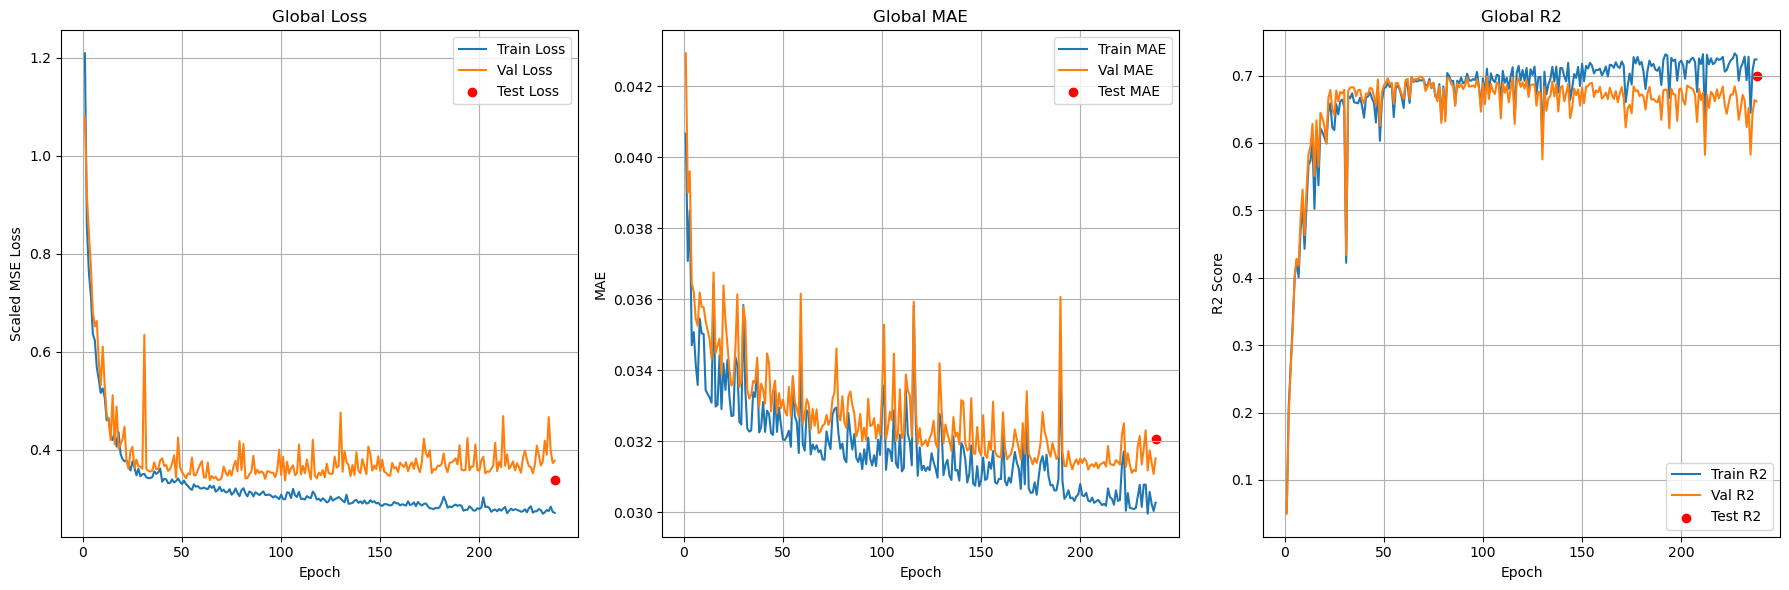

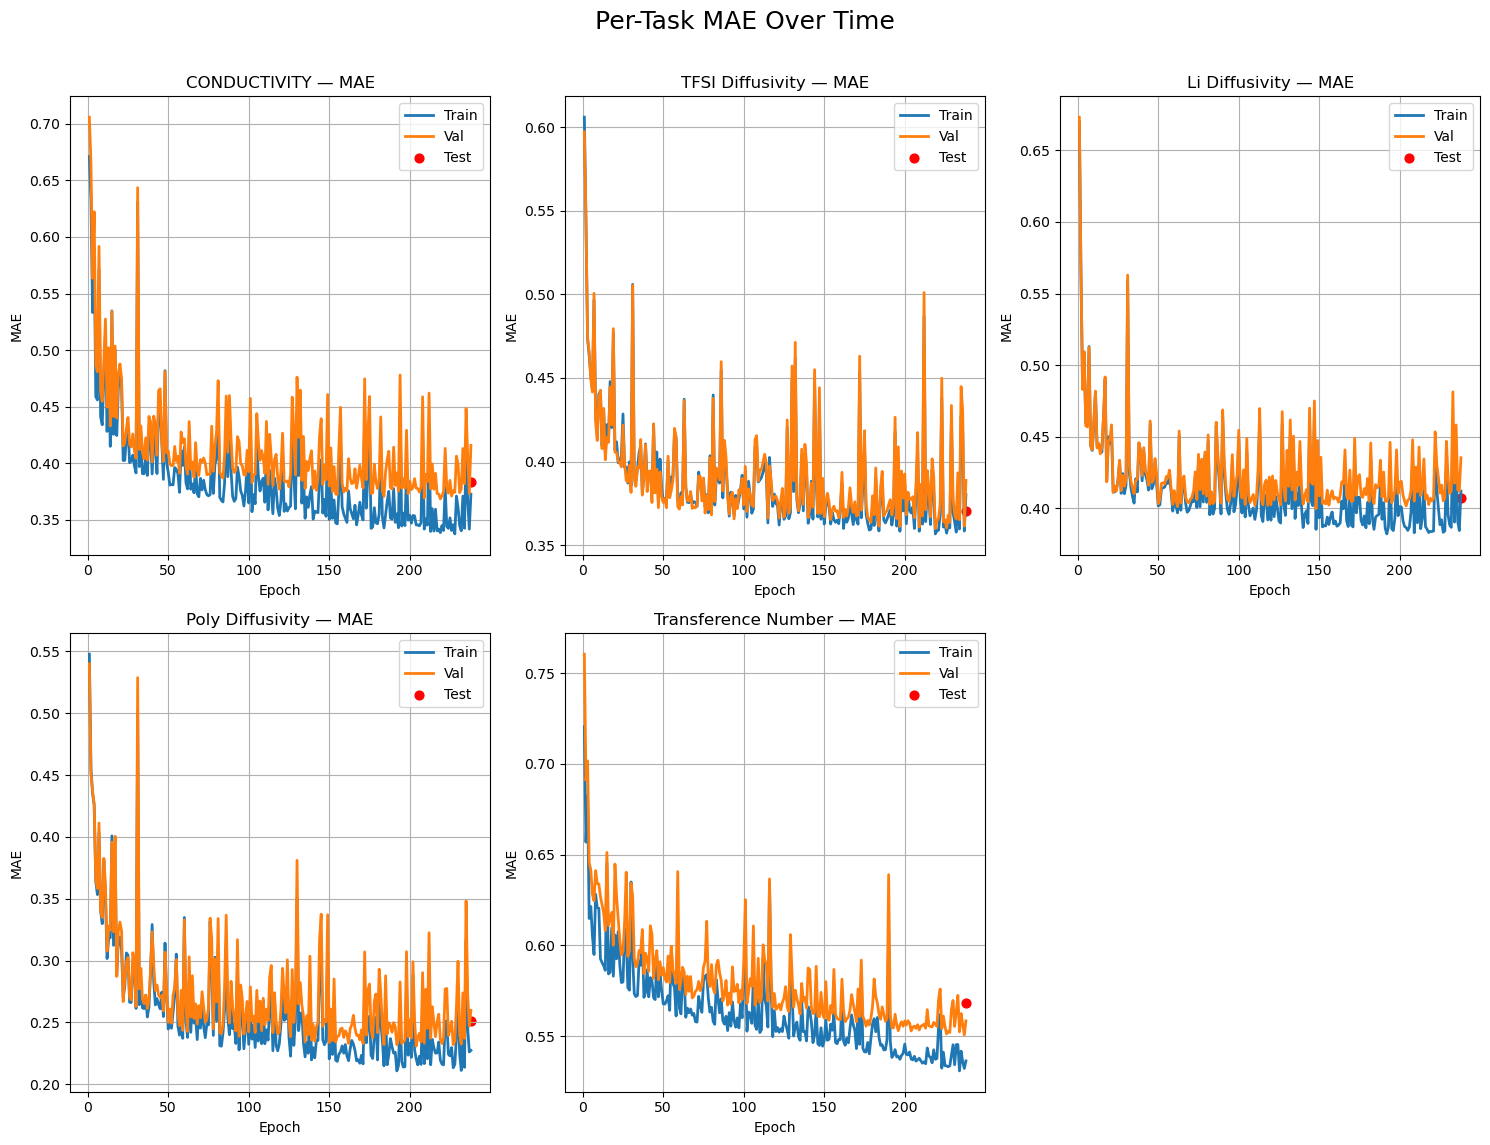

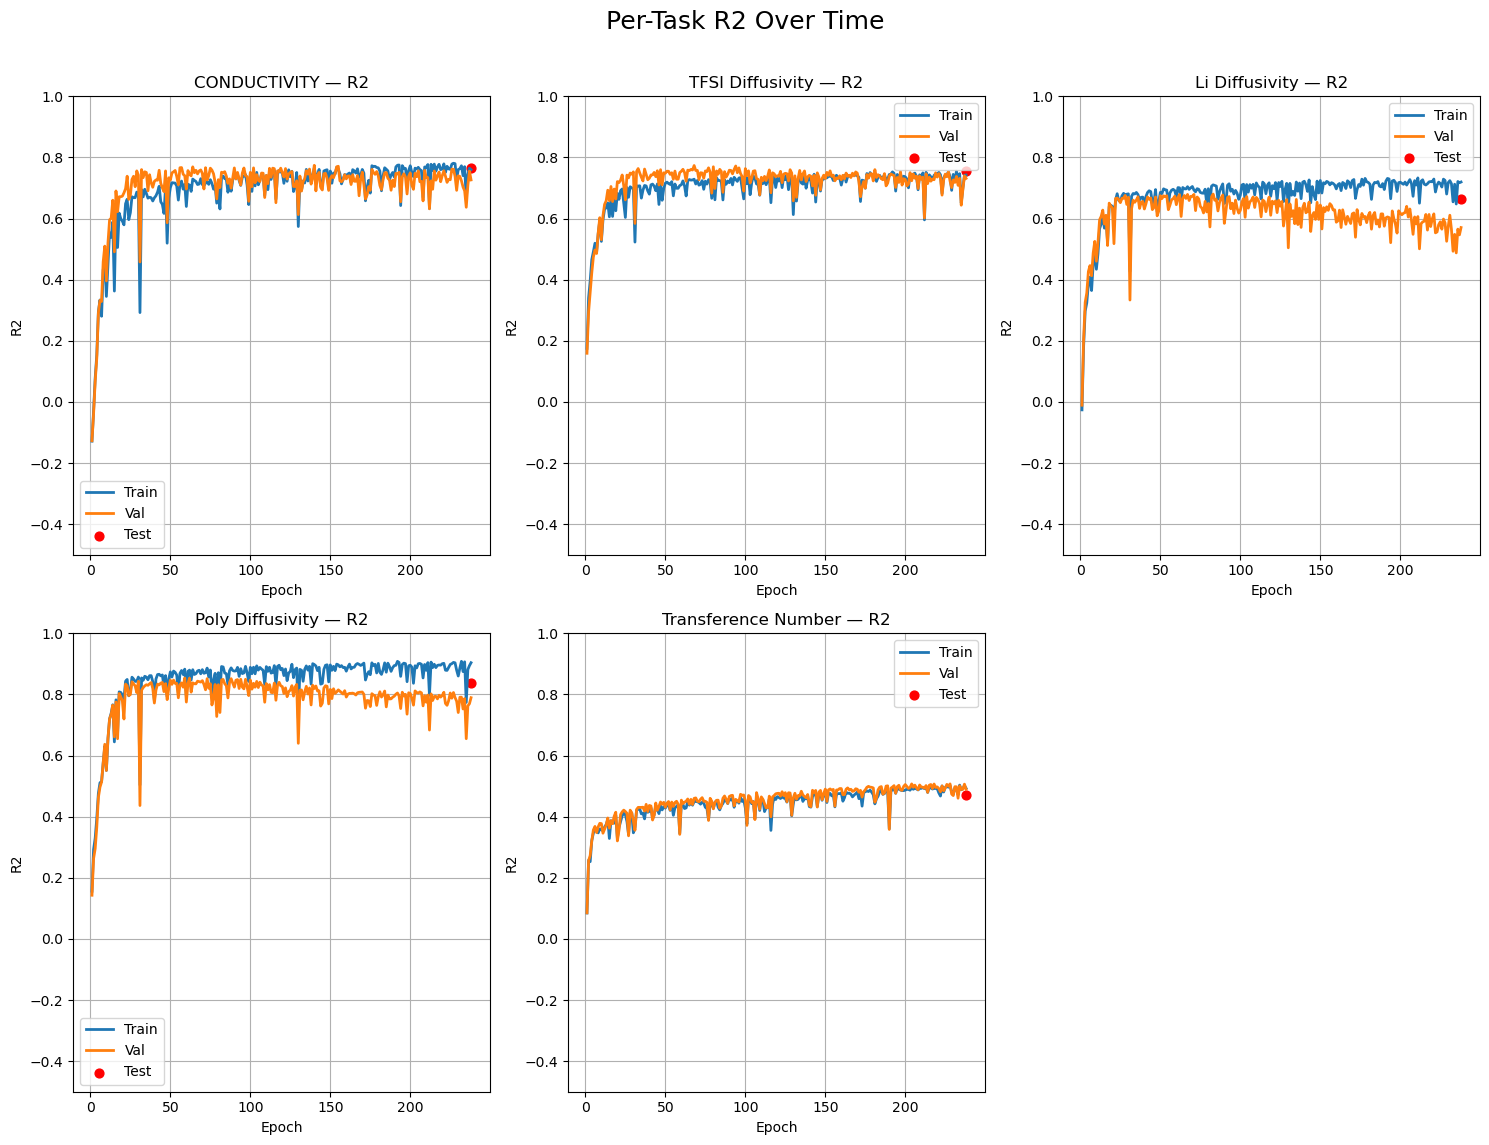

In [ ]:
print('Best score (no molecular features):',score_nomol)
plot_all_metrics(final_metrics_nomol, target_cols_labels, num_epochs=best_params_nomol["num_epochs"])

In [ ]:
print('Best score (with molecular features):',score_withmol)
plot_all_metrics(final_metrics_withmol, target_cols_labels, num_epochs=best_params_withmol["num_epochs"]) #final_metrics3, best_params

In [ ]:
torch.save(final_model_nomol,'./model_out/optimal_model_nomol.pth')
with open("./model_out/optimal_model_nomol_params.txt", "w") as file:
    for k, v in best_params_nomol.items():
        file.write(f"{k}: {v}\n")

torch.save(final_model_withmol,'./model_out/optimal_model_withmol.pth')
with open("./model_out/optimal_model_withmol_params.txt", "w") as file:
    for k, v in best_params_withmol.items():
        file.write(f"{k}: {v}\n")

# BELOW NEEDS TO BE DELETED FOR FINAL SUBMISSION

In [ ]:
# old_combined = pd.read_csv('./data/combined_featurized_data.csv')
# old_featurized = pd.read_csv('./data/featurized_ionic_conductivity_dataset.csv')

NameError: name 'pd' is not defined

In [ ]:
# # old_combined.info()
# old_featurized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6137 entries, 0 to 6136
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Molality                        6137 non-null   float64
 1   Monomer Molecular Weight        6137 non-null   float64
 2   Degree of Polymerization        6137 non-null   float64
 3   CONDUCTIVITY                    6137 non-null   float64
 4   Mol_smiles_clean                6137 non-null   object 
 5   is_valid                        6137 non-null   bool   
 6   Topological_diameter_bonds      6137 non-null   float64
 7   BRICS_unique_frag_count         6137 non-null   int64  
 8   BRICS_largest_frag_heavy_atoms  6137 non-null   int64  
 9   Fgroup_carbonyl                 6137 non-null   int64  
 10  Fgroup_ester                    6137 non-null   int64  
 11  Fgroup_amide                    6137 non-null   int64  
 12  Fgroup_ether                    61

In [ ]:
# unique_cols1 = set()
# unique_cols2 = set()
# shared_cols = set()

# for col1 in old_combined.columns:
#     if col1 not in old_featurized.columns:
#         unique_cols1.add(col1)
#     else:
#         shared_cols.add(col1)

# for col2 in old_featurized.columns:
#     if col2 not in old_combined.columns:
#         unique_cols2.add(col2)
#     else:
#         shared_cols.add(col2)

# print(f'Shared columns ({len(shared_cols)}): \n{shared_cols}\n')
# print(f'Columns unique to old_combined ({len(unique_cols1)}): \n{unique_cols1}\n')
# print(f'Columns unique to old_featurized ({len(unique_cols2)}): \n{unique_cols2}\n')


Shared columns (19): 
{'EState_std', 'NumHAcceptors', 'RingCount', 'Molality', 'AromaticAtomCount', 'NumRotatableBonds', 'EState_max', 'Monomer Molecular Weight', 'Degree of Polymerization', 'EState_sum', 'FractionCSP3', 'MolLogP', 'Topological_diameter_bonds', 'NumHDonors', 'TPSA', 'Mol_smiles_clean', 'CONDUCTIVITY', 'is_valid', 'SASA_sum'}

Columns unique to old_combined (45): 
{'EState_mean', 'FG_carbonyl', 'Count_O', 'Count_Si', 'FG_tertiary_amine', 'Poly Diffusivity', 'NumAliphaticRings', 'Count_C', 'Count_F', 'EState_min', 'Longest_chain_atoms_est', 'MeanCharge', 'Heteroatom_count', 'Li Diffusivity', 'NumAromaticRings', 'Transference Number', 'Count_Cl', 'MinCharge', 'FG_phosphate', 'Kappa1', 'HeavyAtomCount', 'Kappa2', 'Num_positive_atoms', 'Count_P', 'FG_aromatic_ring', 'Total_formal_charge', 'Count_S', 'MaxCharge', 'Num_negative_atoms', 'LabuteASA', 'FG_amine_secondary', 'TFSI Diffusivity', 'TPSA_ratio', 'Chi1', 'FG_sulfonyl', 'Count_N', 'MolCharge', 'FG_amine_primary', 'FG_th

In [ ]:
# merge_keys = ["Mol_smiles_clean", "CONDUCTIVITY"]

# merged = old_combined.merge(
#     old_featurized.drop_duplicates(merge_keys),
#     on=merge_keys,
#     how="inner",       # keep only rows that match featurized entries
#     suffixes=("", "_feat")
# )


In [ ]:
# pd.set_option('display.max_columns', None)

In [ ]:
# merged.head()

,row_index,Molality,Monomer Molecular Weight,Degree of Polymerization,CONDUCTIVITY,Mol_smiles_clean,is_valid,Count_P,Count_Cl,Count_O,Count_Si,Count_C,Count_F,Count_N,Count_S,Heteroatom_count,Topological_diameter_bonds,Longest_chain_atoms_est,MolWt,MolLogP,LogP,TPSA,TPSA_ratio,NumHDonors,NumHAcceptors,NumRotatableBonds,HeavyAtomCount,LabuteASA,Chi0,Chi1,Kappa1,Kappa2,FractionCSP3,RingCount,NumAromaticRings,NumAliphaticRings,MolCharge,MaxCharge,MinCharge,MeanCharge,FG_carbonyl,FG_ester,FG_amine_primary,FG_amine_secondary,FG_tertiary_amine,FG_sulfonyl,FG_thiol,FG_phosphate,FG_ether,FG_aromatic_ring,AromaticAtomCount,EState_sum,EState_mean,EState_max,EState_min,EState_std,Total_formal_charge,Num_positive_atoms,Num_negative_atoms,SASA_sum,TFSI Diffusivity,Li Diffusivity,Poly Diffusivity,Transference Number,Molality_feat,Monomer Molecular Weight_feat,Degree of Polymerization_feat,is_valid_feat,Topological_diameter_bonds_feat,BRICS_unique_frag_count,BRICS_largest_frag_heavy_atoms,Fgroup_carbonyl,Fgroup_ester,Fgroup_amide,Fgroup_ether,Fgroup_alcohol,RingCount_feat,AromaticAtomCount_feat,Hybrid_SP,Hybrid_SP2,Hybrid_SP3,NumHDonors_feat,NumHAcceptors_feat,EState_sum_feat,EState_max_feat,EState_std_feat,Gasteiger_max,Gasteiger_min,Gasteiger_mean,Gasteiger_std,SASA_sum_feat,MolLogP_feat,TPSA_feat,NumRotatableBonds_feat,FractionCSP3_feat,R_eff,D,Tg,eta
0,0,1.4005,467.71,19.0,0.000076,COCC(CNCC(CF)OC(=O))O,True,0,0,4,0,8,1,1,0,1,10.0,11,209.217,-0.9056,-0.9056,67.79,0.324018,2,5,9,14,82.192090,10.811555,6.739912,13.28,8.859729,0.875000,0,0,0,0,0.292994,-0.460432,-0.087493,1,1,0,1,1,0,0,0,2,0,0,43.166667,3.083333,12.105997,-0.789588,4.210616,0,0,0,82.192090,3.229400e-08,1.260800e-08,1.526400e-08,-0.162760,1.4005,467.71,19.0,True,10.0,5,4,1,1,0,2,1,0,0,0,3,11,2,5,43.166667,12.105997,4.210616,0.292994,-0.460432,-0.087493,0.233611,104.816345,-0.9056,67.79,9,0.875000,7.762332e-10,3.330923e-10,101.329,115.672374
1,1,1.4735,475.72,13.0,0.000070,O=C(CCNC(=O)COC(=O))NCCN,True,0,0,4,0,8,0,3,0,0,12.0,13,217.225,-2.2594,-2.2594,110.52,0.508781,3,5,8,15,87.331572,11.518662,7.201907,13.37,8.945978,0.625000,0,0,0,0,0.293089,-0.457795,-0.083026,3,1,1,2,3,0,0,0,1,0,0,46.333333,3.088889,10.992087,-0.436366,4.063489,0,0,0,87.331572,1.317300e-08,1.105800e-08,8.636900e-09,0.317530,1.4735,475.72,13.0,True,12.0,5,4,3,1,2,1,0,0,0,0,9,6,3,5,46.333333,10.992087,4.063489,0.293089,-0.457795,-0.083026,0.246671,108.638356,-2.2594,110.52,8,0.625000,7.806394e-10,3.312123e-10,111.676,178.396166
2,2,1.4422,462.68,17.0,0.000104,NC(=O)C(COC(=O))NC(=O)CCO,True,0,0,5,0,7,0,2,0,0,9.0,10,204.182,-2.4881,-2.4881,118.72,0.581442,3,5,7,14,80.211002,10.974691,6.612591,12.37,6.839985,0.571429,0,0,0,0,0.292667,-0.465137,-0.089431,3,1,1,1,2,0,0,0,1,0,0,48.166667,3.440476,10.898291,-1.056250,4.502828,0,0,0,80.211002,1.397400e-08,1.952200e-08,9.183200e-09,0.529740,1.4422,462.68,17.0,True,9.0,4,5,3,1,2,1,1,0,0,0,9,5,3,5,48.166667,10.898291,4.502828,0.292667,-0.465137,-0.089431,0.262205,97.331488,-2.4881,118.72,7,0.571429,7.734405e-10,3.342951e-10,113.012,197.425505
3,3,1.4327,476.75,16.0,0.000027,CC(COC(=O))COC(=O)C(C)(C)CO,True,0,0,5,0,10,0,0,0,0,10.0,11,218.249,0.3572,0.3572,72.83,0.333701,1,5,7,15,89.368098,11.897341,6.935887,13.90,6.396026,0.800000,0,0,0,0,0.313355,-0.467479,-0.067783,2,2,0,0,0,0,0,0,2,0,0,43.750000,2.916667,11.381498,-0.883694,3.946091,0,0,0,89.368098,2.421000e-08,1.192500e-08,1.402700e-08,-0.319160,1.4327,476.75,16.0,True,10.0,4,7,2,2,0,2,1,0,0,0,6,9,1,5,43.750000,11.381498,3.946091,0.313355,-0.467479,-0.067783,0.241140,114.744238,0.3572,72.83,7,0.800000,7.812024e-10,3.309736e-10,105.241,131.387016
4,4,1.4680,477.69,26.0,0.000038,COC(=O)CC(=O)NC(CO)COC(=O),True,0,0,6,0,8,0,1,0,0,10.0,11,219.193,-1.8004,-1.8004,101.93,0.465024,2,6,7,15,86.349599,11.681798,7.133759,13.37,7.744209,0.625000,0,0,0,0,0.314539,-0.468620,-0.076548,3,2,0,1,1,0,0,0,2,0,0,49.666667,3.311111,11.077874,-0.715411,4.407540,0,0,0,86.349599,1.349100e-08,6.582900e-09,8.672500e-09,0.080645,1.4680,477.6

In [ ]:
# merged.drop(['row_index','is_valid','is_valid_feat'], axis=1).to_csv('./data/temp_full_data.csv')